In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import math as m
import pbdlib as pbd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from pbdlib.utils.jupyter_utils import *
np.set_printoptions(precision=2)

Import data

In [2]:
dp = os.path.dirname(pbd.__file__) + '/data/demos/placing'
filelist = next(os.walk(dp))[2]
filelist_short = filelist[0:5]
data = []
for f in filelist_short:
    temp = np.genfromtxt(dp + '/' + f, delimiter=',')
    data.append(temp[1:,[9, 10, 11, 17, 18, 19]])

IndexError: index 9 is out of bounds for axis 1 with size 2

In [3]:
t = np.linspace(0, 100, data[0].shape[0])

In [4]:
# Fix for start and end frame
data_start = []
data_end = []

for p in data:
    # Set start point
    start = p[0,:]
    arr_trans = np.apply_along_axis(pbd.utils.transform_matrix_3D, 1, p, start)
    data_start.append(arr_trans)

for p in data:
    # Set end point
    end = p[-1,:]
    arr_trans = np.apply_along_axis(pbd.utils.transform_matrix_3D, 1, p, end)
    data_end.append(arr_trans)

Text(0.5,0.98,'Y-Z plot of 5 demonstrated trajectories')

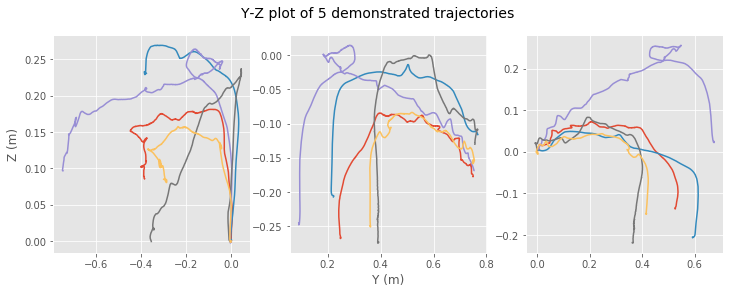

In [6]:
# plotting
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(12,4)
Y = 2
X = 1
for p in data_start:
    ax[0].plot(p[:, X], p[:, Y])
    
for p in data:
    ax[1].plot(p[:, X], p[:, Y])
    
for p in data_end:
    ax[2].plot(p[:, X], p[:, Y])
    
ax[1].set_xlabel("Y (m)", fontsize=12)
ax[0].set_ylabel("Z (m)", fontsize=12)
fig.suptitle("Y-Z plot of 5 demonstrated trajectories", fontsize=14)

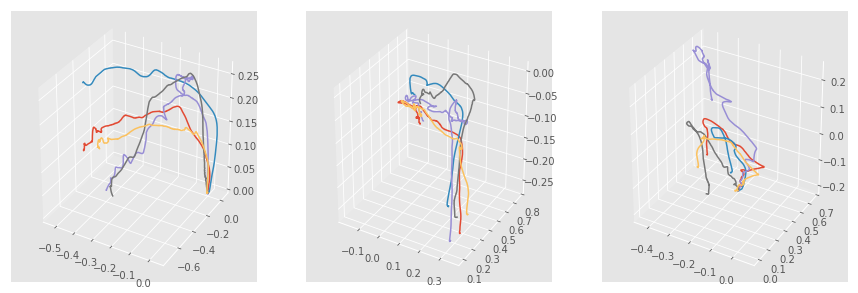

In [71]:
# 3d plot
fig = plt.figure()
fig.set_size_inches(15,5)
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

for p in data:
    ax2.plot(p[:, 0], p[:, 1], p[:, 2])

for p in data_start:
    ax1.plot(p[:, 0], p[:, 1], p[:, 2])

for p in data_end:
    ax3.plot(p[:, 0], p[:, 1], p[:, 2])

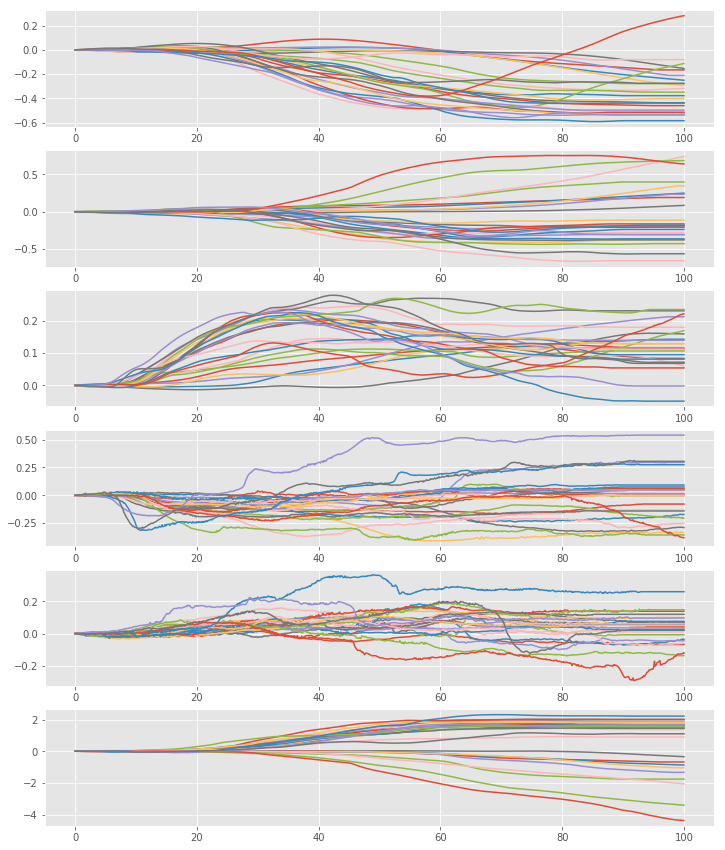

In [7]:
# plotting
fig, ax = plt.subplots(nrows=6)
fig.set_size_inches(12,15)
for i in range(6):
    for p in data_start:
        ax[i].plot(t, p[:, i])

In [6]:
gmm_demos = [np.hstack([t[:,None], s, e]) for e in data_end for s in data_start]
gmm_demos2 = np.vstack([d for d in gmm_demos])

gmm = pbd.GMM(nb_dim=13, nb_states=5)

gmm.init_hmm_kbins(gmm_demos)

gmm.em(gmm_demos2, reg=0.0)

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
cost = 0
repros = []

for i in range(len(data)):
    A0 = np.identity(n=7)
    An = np.identity(n=7)
    b0 = np.zeros(7)
    bn = np.zeros(7)
    A0[1:7,1:7], b0[1:7] = pbd.utils.inv_for_lintrans(data[i][0,:])
    An[1:7,1:7], bn[1:7] = pbd.utils.inv_for_lintrans(data[i][-1,:])
        
    dim1 = np.array([0, 1, 2, 3, 4,  5,  6])
    dim2 = np.array([0, 7, 8, 9, 10, 11, 12])

    _mod1 = gmm.marginal_model(dim1).lintrans(A0, b0)
    _mod2 = gmm.marginal_model(dim2).lintrans(An, bn)
    
    # product 
    _prod = _mod1 * _mod2
    
    # get the most probable trajectory for this demonstration
    _mu, _sigma = _prod.condition(t[:, None], dim_in=slice(0, 1), dim_out=slice(0, 7))
    
    repros.append(_mu[:,1:])

AttributeError: 'numpy.ndarray' object has no attribute 'start'

In [9]:
A0 = np.identity(n=7)
An = np.identity(n=7)
b0 = np.zeros(7)
bn = np.zeros(7)
A0[1:7,1:7], b0[1:7] = pbd.utils.inv_for_lintrans(data[i][0,:])
An[1:7,1:7], bn[1:7] = pbd.utils.inv_for_lintrans(data[i][-1,:])

dim1 = np.array([0, 1, 2, 3, 4,  5,  6])
dim2 = np.array([0, 7, 8, 9, 10, 11, 12])

_mod1 = gmm.marginal_model(dim1)
_mod2 = gmm.marginal_model(dim2)

In [10]:
_mod1.sigma.shape

(5, 7, 7)

In [25]:
pbd.utils.cost_function(data, repros)

31.09510404717505